<a href="https://colab.research.google.com/github/gulierus/VU_RG/blob/main/HOW_PFN_APPROX_GP_KERNEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =============================================
# SETUP - Nový PFNs repozitář
# =============================================
import os
os.chdir('/content')

!rm -rf /content/PFNs
!cd /content && git clone https://github.com/automl/PFNs.git
!cd /content/PFNs && pip install -e . -q

print("PFNs nainstalováno")


Cloning into 'PFNs'...
remote: Enumerating objects: 1016, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1016 (delta 227), reused 206 (delta 206), pack-reused 758 (from 1)
Receiving objects: 100% (1016/1016), 95.54 MiB | 30.71 MiB/s, done.
Resolving deltas: 100% (710/710), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 657.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6

In [3]:
# =============================================
# IMPORTS
# =============================================
import sys
sys.path.insert(0, '/content/PFNs')

import math
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from pfns import utils
from pfns.model import bar_distribution
from pfns.train import train, MainConfig, OptimizerConfig, TransformerConfig, BatchShapeSamplerConfig
from pfns.model.encoders import EncoderConfig
from pfns.model.bar_distribution import BarDistributionConfig
from pfns.priors.prior import AdhocPriorConfig
from pfns.priors import Batch
from pfns.priors.fast_gp import get_batch as get_batch_for_gp

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Device: {device}")
print(f"✓ PyTorch: {torch.__version__}")

✓ Device: cpu
✓ PyTorch: 2.9.0+cpu


In [21]:
# =============================================
# NAČTENÍ MODELU A INFERENCE
# =============================================
# @title NAČTENÍ MODELU A INFERENCE

from google.colab import drive

# Připojení Google Disku (pokud ještě není)
try:
    drive.mount('/content/drive')
except:
    pass

# Cesta k modelu
save_dir = '/content/drive/MyDrive/UZNATONEMAMNERVY/PFN_GP_model'
checkpoint_path = f'{save_dir}/pfn_gp_model.pth'

# --- NAČTENÍ MODELU ---
print(f"Loading model from {checkpoint_path}...")
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Extrahuj uloženou konfiguraci
config = checkpoint['config']
hps = config['hps']
num_features = config['num_features']
max_dataset_size = config['max_dataset_size']

print(f"Config: hps={hps}, num_features={num_features}, max_dataset_size={max_dataset_size}")

# Rekonstruuj model - spustíme MINIMÁLNÍ trénink jen pro vytvoření struktury
# Použijeme uložený criterion
criterion = checkpoint['criterion']
borders = criterion.borders.tolist()

# Vytvoř STEJNOU konfiguraci jako při tréninku
model_config = MainConfig(
    priors=[AdhocPriorConfig(
        get_batch_methods=[get_batch_for_gp],
        prior_kwargs={'num_features': num_features, 'hyperparameters': hps}
    )],
    optimizer=OptimizerConfig('adamw', lr=0.0003),
    model=TransformerConfig(
        criterion=BarDistributionConfig(full_support=True, borders=borders),
        emsize=512,
        nhead=8,
        nhid=1024,
        nlayers=6,
        features_per_group=1,
        attention_between_features=False,
        encoder=EncoderConfig(
            constant_normalization_mean=0.5,
            constant_normalization_std=math.sqrt(1/12)
        )
    ),
    batch_shape_sampler=BatchShapeSamplerConfig(
        batch_size=2,
        max_seq_len=max_dataset_size,
        min_num_features=num_features,
        max_num_features=num_features
    ),
    epochs=1,
    steps_per_epoch=1,  # Minimální - jen pro vytvoření modelu
    num_workers=0,
)

# Spusť minimální trénink pro získání struktury modelu
print("Vytvářím strukturu modelu...")
dummy_result = train(model_config, device=device, reusable_config=False)
loaded_model = dummy_result['model']

# Načti uložené váhy
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.criterion = criterion
loaded_model.to(device)
loaded_model.eval()

print("✓ Model úspěšně načten!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from /content/drive/MyDrive/UZNATONEMAMNERVY/PFN_GP_model/pfn_gp_model.pth...
Config: hps={'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.3}, num_features=1, max_dataset_size=50
Vytvářím strukturu modelu...
init dist
Not using distributed
ALL: Using device cpu.
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<pfns.priors.fast_gp.get_batch (batch_size, seq_len, num_features, device='cpu', hyperparameters=None, equidistant_x=False, fix_x=None, **kwargs)
), num_features=1, hyperparameters={'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.3}), 'num_steps': 1, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=2, min_single_eval_pos=0, max_seq_len=50, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 

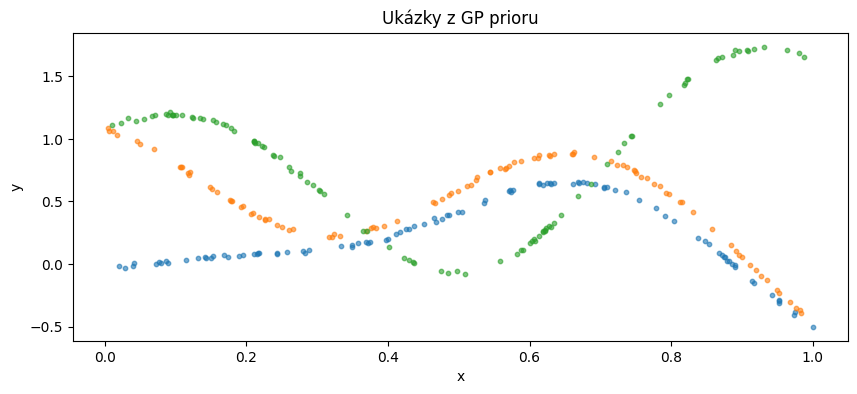

Batch shapes: x=torch.Size([3, 100, 1]), y=torch.Size([3, 100])


In [5]:
# =============================================
# GP PRIOR - Sampling funkce
# =============================================

# Ukázka dat z GP prioru
hps_gp = {"noise": 1e-4, "outputscale": 1., "lengthscale": 0.3}

batch = get_batch_for_gp(batch_size=3, seq_len=100, num_features=1, hyperparameters=hps)

plt.figure(figsize=(10, 4))
for i in range(len(batch.x)):
    plt.scatter(batch.x[i, :, 0].cpu().numpy(), batch.y[i, :].cpu().numpy(), alpha=0.6, s=10)
plt.title('Ukázky z GP prioru')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(f"Batch shapes: x={batch.x.shape}, y={batch.y.shape}")

In [22]:
# =============================================
# EXPERIMENT 1: Výpočet Attention vah
# =============================================
import torch.nn.functional as F

def compute_attention_weights(model, train_x, train_y, test_x):
    """
    Zachytí vstupy do attention a manuálně vypočítá attention váhy.
    """
    model.eval()

    layer_inputs = []

    def input_hook(module, inputs, output):
        layer_inputs.append(inputs[0].detach().cpu())

    # Hook na attention vrstvy
    hooks = []
    attn_modules = []
    for name, module in model.named_modules():
        if 'self_attn_between_items' in name and 'self_attn_between_items.' not in name:
            hooks.append(module.register_forward_hook(input_hook))
            attn_modules.append(module)

    with torch.no_grad():
        _ = model(train_x[None], train_y[None], test_x[None])

    for hook in hooks:
        hook.remove()

    # Vypočítej attention váhy pro každou vrstvu
    all_attention_weights = []

    for layer_idx, module in enumerate(attn_modules):
        if layer_idx >= len(layer_inputs):
            break

        x = layer_inputs[layer_idx]
        w_qkv = module.w_qkv.cpu()

        batch, features, seq_len, embed_dim = x.shape
        n_heads = w_qkv.shape[1]
        head_dim = w_qkv.shape[2]

        x_flat = x.reshape(-1, embed_dim)

        W_q = w_qkv[0]
        W_k = w_qkv[1]

        W_q_t = W_q.permute(2, 0, 1)
        W_k_t = W_k.permute(2, 0, 1)

        Q = torch.matmul(x_flat, W_q_t.reshape(embed_dim, -1)).reshape(-1, n_heads, head_dim)
        K = torch.matmul(x_flat, W_k_t.reshape(embed_dim, -1)).reshape(-1, n_heads, head_dim)

        Q = Q.reshape(batch, features, seq_len, n_heads, head_dim)
        K = K.reshape(batch, features, seq_len, n_heads, head_dim)

        Q = Q.permute(0, 1, 3, 2, 4)
        K = K.permute(0, 1, 3, 2, 4)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)

        all_attention_weights.append(attn_weights)

    return all_attention_weights, layer_inputs

# Test
batch = get_batch_for_gp(batch_size=1, seq_len=50, num_features=1, hyperparameters=hps)
n_context = 20

train_x = batch.x[0, :n_context]
train_y = batch.y[0, :n_context]
test_x = batch.x[0]

attn_weights, layer_inputs = compute_attention_weights(loaded_model, train_x, train_y, test_x)

print(f"Počet vrstev: {len(attn_weights)}")
for i, w in enumerate(attn_weights):
    print(f"Vrstva {i}: attention shape = {w.shape}")

Počet vrstev: 6
Vrstva 0: attention shape = torch.Size([1, 1, 8, 70, 70])
Vrstva 1: attention shape = torch.Size([1, 1, 8, 70, 70])
Vrstva 2: attention shape = torch.Size([1, 1, 8, 70, 70])
Vrstva 3: attention shape = torch.Size([1, 1, 8, 70, 70])
Vrstva 4: attention shape = torch.Size([1, 1, 8, 70, 70])
Vrstva 5: attention shape = torch.Size([1, 1, 8, 70, 70])


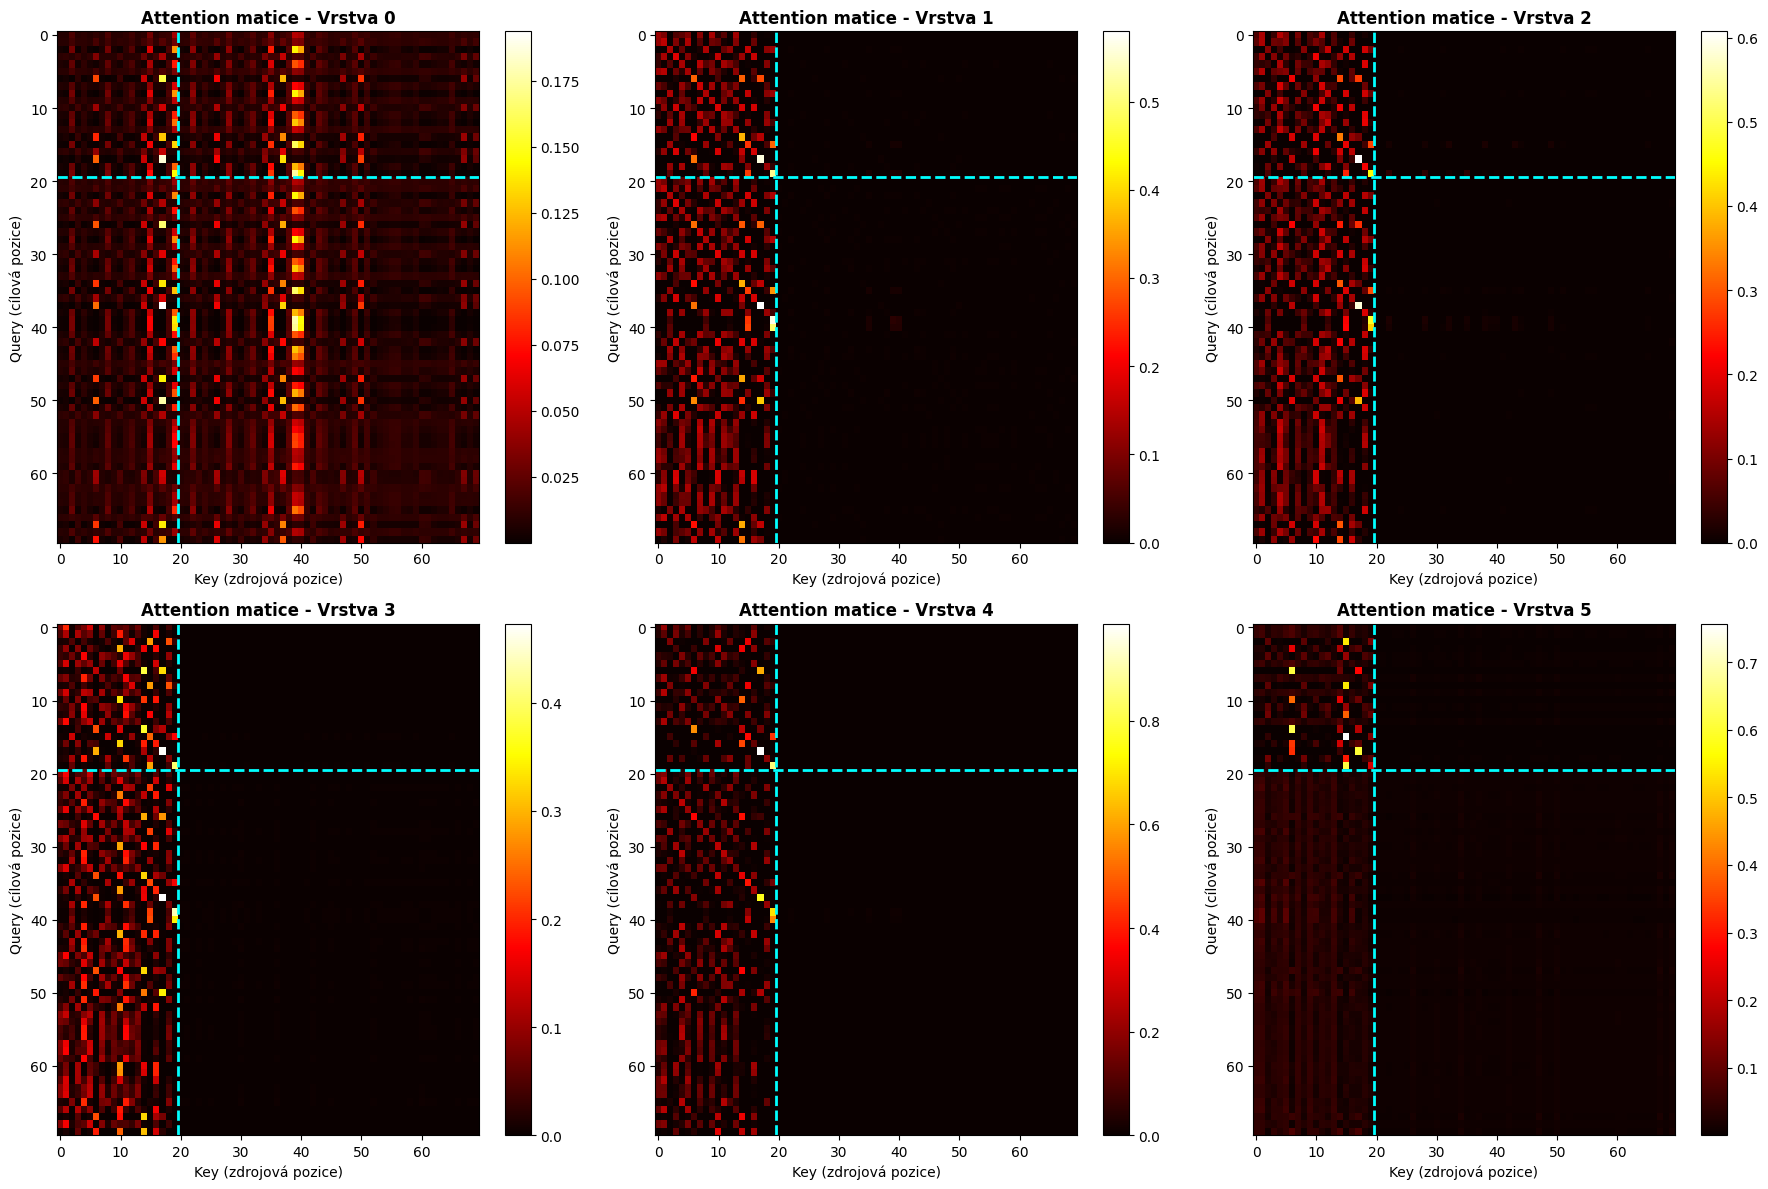

In [23]:
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 12))
axes1 = axes1.flatten()

for layer_idx in range(6):
    # Průměr přes všechny heads
    attn_layer = attn_weights[layer_idx][0, 0].mean(dim=0).detach().numpy()  # [seq_len, seq_len]

    ax = axes1[layer_idx]
    im = ax.imshow(attn_layer, cmap='hot', aspect='auto')
    ax.axhline(y=n_context-0.5, color='cyan', linestyle='--', lw=2)
    ax.axvline(x=n_context-0.5, color='cyan', linestyle='--', lw=2)
    ax.set_xlabel('Key (zdrojová pozice)')
    ax.set_ylabel('Query (cílová pozice)')
    ax.set_title(f'Attention matice - Vrstva {layer_idx}', fontweight='bold')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()




*   Zde je ukázka attention matic pro různé vrstvy, díky níž můžeme pozorovat, zda transformer se naučil nějaký konkretní pattern, nebo naučil se složitější struktury.
*   Každá matice je rozdělená na kvadranty podle počtu trénovaících a testovacích bodů a jejich vzajemných vztahů, tj. jak na sebe navzájem davají pozor.

* Vlevo nahoře : Train→Train attention,

  vpravo nahoře: Train→Test attention,

  vlevo dole: Test→Train attention,

  vpravo dole: Test→Test attention.

* Je vidět, že transformer postupně odhalil, že trénovací data nezávísí na testovacích a testovací data nějakým způsobem závísí na trénovacích datech. Což je zcela sprváná logika, kterou transformer dokázal odhalit sám.

* Struktura těchto matic je vlastně náznákem, že PFN dělá Bayesian inference, ne jen pattern matching. Kdyby se PFN jen učil nazpaměť trénovací data, attention by byla symetrická — všechny kvadranty podobně aktivní.


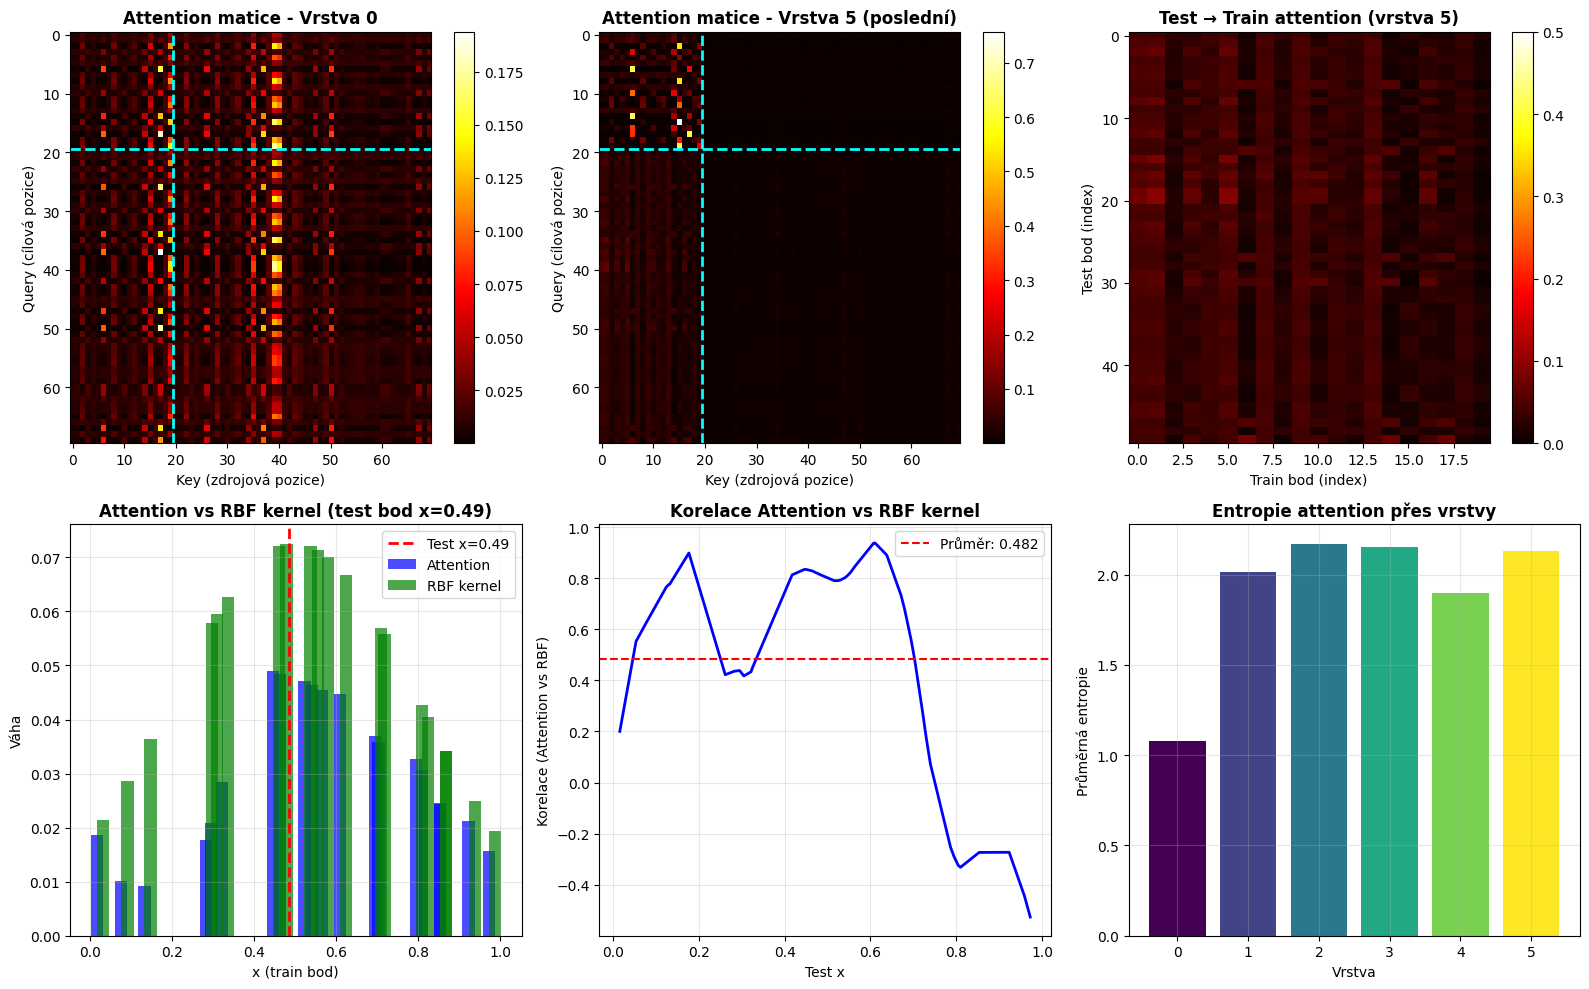


Průměrná korelace Attention vs RBF: 0.4824
Vyšší korelace = PFN se naučil kernel-like chování


In [24]:
# =============================================
# VIZUALIZACE ATTENTION VAH
# =============================================

# Průměr přes všechny heads
attn_layer0 = attn_weights[0][0, 0].mean(dim=0).detach().numpy()  # [70, 70]
attn_layer5 = attn_weights[5][0, 0].mean(dim=0).detach().numpy()  # [70, 70]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Attention matice - vrstva 0
ax = axes[0, 0]
im = ax.imshow(attn_layer0, cmap='hot', aspect='auto')
ax.axhline(y=n_context-0.5, color='cyan', linestyle='--', lw=2)
ax.axvline(x=n_context-0.5, color='cyan', linestyle='--', lw=2)
ax.set_xlabel('Key (zdrojová pozice)')
ax.set_ylabel('Query (cílová pozice)')
ax.set_title('Attention matice - Vrstva 0', fontweight='bold')
plt.colorbar(im, ax=ax)

# 2. Attention matice - vrstva 5 (poslední)
ax = axes[0, 1]
im = ax.imshow(attn_layer5, cmap='hot', aspect='auto')
ax.axhline(y=n_context-0.5, color='cyan', linestyle='--', lw=2)
ax.axvline(x=n_context-0.5, color='cyan', linestyle='--', lw=2)
ax.set_xlabel('Key (zdrojová pozice)')
ax.set_ylabel('Query (cílová pozice)')
ax.set_title('Attention matice - Vrstva 5 (poslední)', fontweight='bold')
plt.colorbar(im, ax=ax)

# 3. Jak test body attendují na train body (vrstva 5)
# Test body jsou indexy n_context:70, train body jsou 0:n_context
test_to_train_attn = attn_layer5[n_context:, :n_context]  # [50, 20]

ax = axes[0, 2]
# DŮLEŽITÉ: použij STEJNÝ rozsah jako vlevo (vmin, vmax)
im = ax.imshow(test_to_train_attn, cmap='hot', aspect='auto',
               vmin=0, vmax=0.5)  # ← PŘIDÁNO
#              ^^^^^^^^^^^^^^
ax.set_xlabel('Train bod (index)')
ax.set_ylabel('Test bod (index)')
ax.set_title('Test → Train attention (vrstva 5)', fontweight='bold')
plt.colorbar(im, ax=ax)

# 4. Attention vs RBF kernel pro jeden test bod
test_idx = 25  # Nějaký test bod (index v test sekvenci)
test_x_val = test_x[test_idx, 0].cpu().item()

# Attention váhy tohoto test bodu na train body
attn_to_train = attn_layer5[n_context + test_idx, :n_context]

# RBF kernel váhy
train_x_np = train_x[:, 0].cpu().numpy()
rbf_weights = np.exp(-0.5 * (train_x_np - test_x_val)**2 / hps['lengthscale']**2)
rbf_weights_norm = rbf_weights / rbf_weights.sum()

# Seřaď podle x
order = np.argsort(train_x_np)

ax = axes[1, 0]
ax.bar(train_x_np[order], attn_to_train[order], width=0.03, alpha=0.7, label='Attention', color='blue')
ax.bar(train_x_np[order] + 0.015, rbf_weights_norm[order], width=0.03, alpha=0.7, label='RBF kernel', color='green')
ax.axvline(x=test_x_val, color='red', linestyle='--', lw=2, label=f'Test x={test_x_val:.2f}')
ax.set_xlabel('x (train bod)')
ax.set_ylabel('Váha')
ax.set_title(f'Attention vs RBF kernel (test bod x={test_x_val:.2f})', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Korelace attention vs RBF pro všechny test body
correlations = []
for i in range(len(test_x)):
    test_x_val = test_x[i, 0].cpu().item()
    attn_to_train = attn_layer5[n_context + i, :n_context]

    rbf_weights = np.exp(-0.5 * (train_x_np - test_x_val)**2 / hps['lengthscale']**2)
    rbf_weights_norm = rbf_weights / rbf_weights.sum()

    corr = np.corrcoef(attn_to_train, rbf_weights_norm)[0, 1]
    correlations.append(corr)

ax = axes[1, 1]
test_x_sorted_idx = test_x[:, 0].cpu().argsort()
ax.plot(test_x[test_x_sorted_idx, 0].cpu().numpy(), np.array(correlations)[test_x_sorted_idx], 'b-', lw=2)
ax.set_xlabel('Test x')
ax.set_ylabel('Korelace (Attention vs RBF)')
ax.set_title('Korelace Attention vs RBF kernel', fontweight='bold')
ax.axhline(y=np.mean(correlations), color='red', linestyle='--', label=f'Průměr: {np.mean(correlations):.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Vývoj attention přes vrstvy
ax = axes[1, 2]
for layer_idx in range(6):
    attn_layer = attn_weights[layer_idx][0, 0].mean(dim=0).detach().numpy()
    test_to_train = attn_layer[n_context:, :n_context]

    # Průměrná "ostrost" attention (entropie)
    entropy = -np.sum(test_to_train * np.log(test_to_train + 1e-10), axis=1).mean()
    ax.bar(layer_idx, entropy, color=plt.cm.viridis(layer_idx/5))

ax.set_xlabel('Vrstva')
ax.set_ylabel('Průměrná entropie')
ax.set_title('Entropie attention přes vrstvy', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrůměrná korelace Attention vs RBF: {np.mean(correlations):.4f}")
print(f"Vyšší korelace = PFN se naučil kernel-like chování")



*   Z detailního průzkumu kvadrantu Test→Train attention v poslední vrstvě je vidět, že PFN nedělá jenom lokální kernel averaging. Kdyby attention byla kernel-like (Nadaraya-Watson), pozorovali bychom pattern v tomto kvadrantu matice. To co my skutečně vidíme je skoro uniformní rozdělení attention mezi body, tj. PFN se naučil aproximovat GP spolu s kernelovou funkci, tj. attention váhy nejsou určené jen vzdáleností (x' - x_train), ale bere v úvahu korelační strukturu mezi train body.
*  Na grafu Attention vs RBF kernel můžeme pozorovat, jaký vliv na konkrétní testovací bod mají jeho okolní body a jak tetno vliv počítá PFN vs RBF. Je zjevné, že PFN se nanučil jenom RBF kernel k(x', x), ale celé GP váhy k(x', x) @ K^{-1}.

* Stejný závěr platí i při pozorování grafu Korelace Attention vs RBF kernel, je vidět, že v některých místech ta korelace může být i záporná.

* Na posledním grafu je znázorněna entropie přes jednotlivé vrstvy. Opět PFN se nenaučil pouze nějaké patterny v datech, on se naučil něco složitějšího.



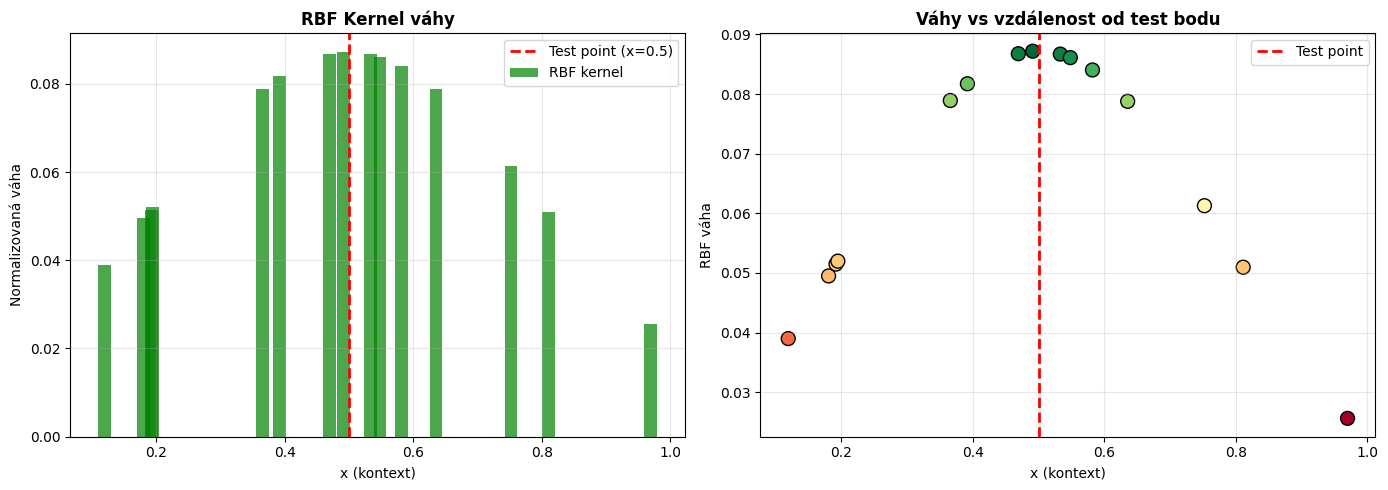

Body blízko x=0.5 mají vyšší váhu (kernel smoothing)


In [25]:
# =============================================
# EXPERIMENT 2: Porovnání Attention vs RBF Kernel
# =============================================
# Hypotéza: Attention váhy by měly korelovat s RBF kernelem

def compute_rbf_kernel(x1, x2, lengthscale=0.3):
    """Vypočítá RBF kernel matrix."""
    x1 = x1.cpu().numpy().reshape(-1, 1) if torch.is_tensor(x1) else x1.reshape(-1, 1)
    x2 = x2.cpu().numpy().reshape(-1, 1) if torch.is_tensor(x2) else x2.reshape(-1, 1)

    # ||x1 - x2||^2
    dist_sq = np.sum(x1**2, axis=1, keepdims=True) + np.sum(x2**2, axis=1) - 2 * x1 @ x2.T
    return np.exp(-0.5 * dist_sq / lengthscale**2)

def compute_attention_similarity(model, train_x, train_y, test_point):
    """
    Aproximuje attention váhy pomocí dot-product similarity embeddings.
    """
    model.eval()

    # Získej embeddings pro všechny body
    all_x = torch.cat([train_x, test_point.unsqueeze(0)], dim=0)
    all_y = torch.cat([train_y, torch.zeros(1).to(train_y.device)], dim=0)

    # Hook pro zachycení embeddings po první vrstvě
    embeddings = []
    def embedding_hook(module, input, output):
        embeddings.append(output.detach().cpu())

    # Najdi encoder vrstvu
    hook = None
    for name, module in model.named_modules():
        if 'encoder' in name.lower() and hasattr(module, 'weight'):
            hook = module.register_forward_hook(embedding_hook)
            break

    with torch.no_grad():
        _ = model(all_x[None], all_y[None], all_x[None])

    if hook:
        hook.remove()

    return embeddings

# Generuj data
batch = get_batch_for_gp(batch_size=1, seq_len=30, num_features=1, hyperparameters=hps)
n_context = 15

train_x = batch.x[0, :n_context, 0]  # (n_context,)
train_y = batch.y[0, :n_context]
test_point = torch.tensor([0.5]).to(train_x.device)

# RBF kernel mezi test bodem a train body
rbf_weights = compute_rbf_kernel(test_point.cpu().numpy(), train_x.cpu().numpy(), lengthscale=hps['lengthscale'])
rbf_weights = rbf_weights.flatten()
rbf_weights_norm = rbf_weights / rbf_weights.sum()  # Normalizuj jako softmax

# Seřaď podle x pro vizualizaci
order = train_x.cpu().argsort()
train_x_sorted = train_x.cpu()[order].numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RBF kernel váhy
ax = axes[0]
ax.bar(train_x_sorted, rbf_weights_norm[order], width=0.02, alpha=0.7, color='green', label='RBF kernel')
ax.axvline(x=0.5, color='red', linestyle='--', lw=2, label='Test point (x=0.5)')
ax.set_xlabel('x (kontext)')
ax.set_ylabel('Normalizovaná váha')
ax.set_title('RBF Kernel váhy', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Porovnání s GP predikcí - váhy by měly být podobné
ax = axes[1]
# Vizualizace: body blíže k test pointu mají vyšší váhu
distances = np.abs(train_x_sorted - 0.5)
ax.scatter(train_x_sorted, rbf_weights_norm[order], c=distances, cmap='RdYlGn_r', s=100, edgecolor='black')
ax.axvline(x=0.5, color='red', linestyle='--', lw=2, label='Test point')
ax.set_xlabel('x (kontext)')
ax.set_ylabel('RBF váha')
ax.set_title('Váhy vs vzdálenost od test bodu', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Body blízko x=0.5 mají vyšší váhu (kernel smoothing)")

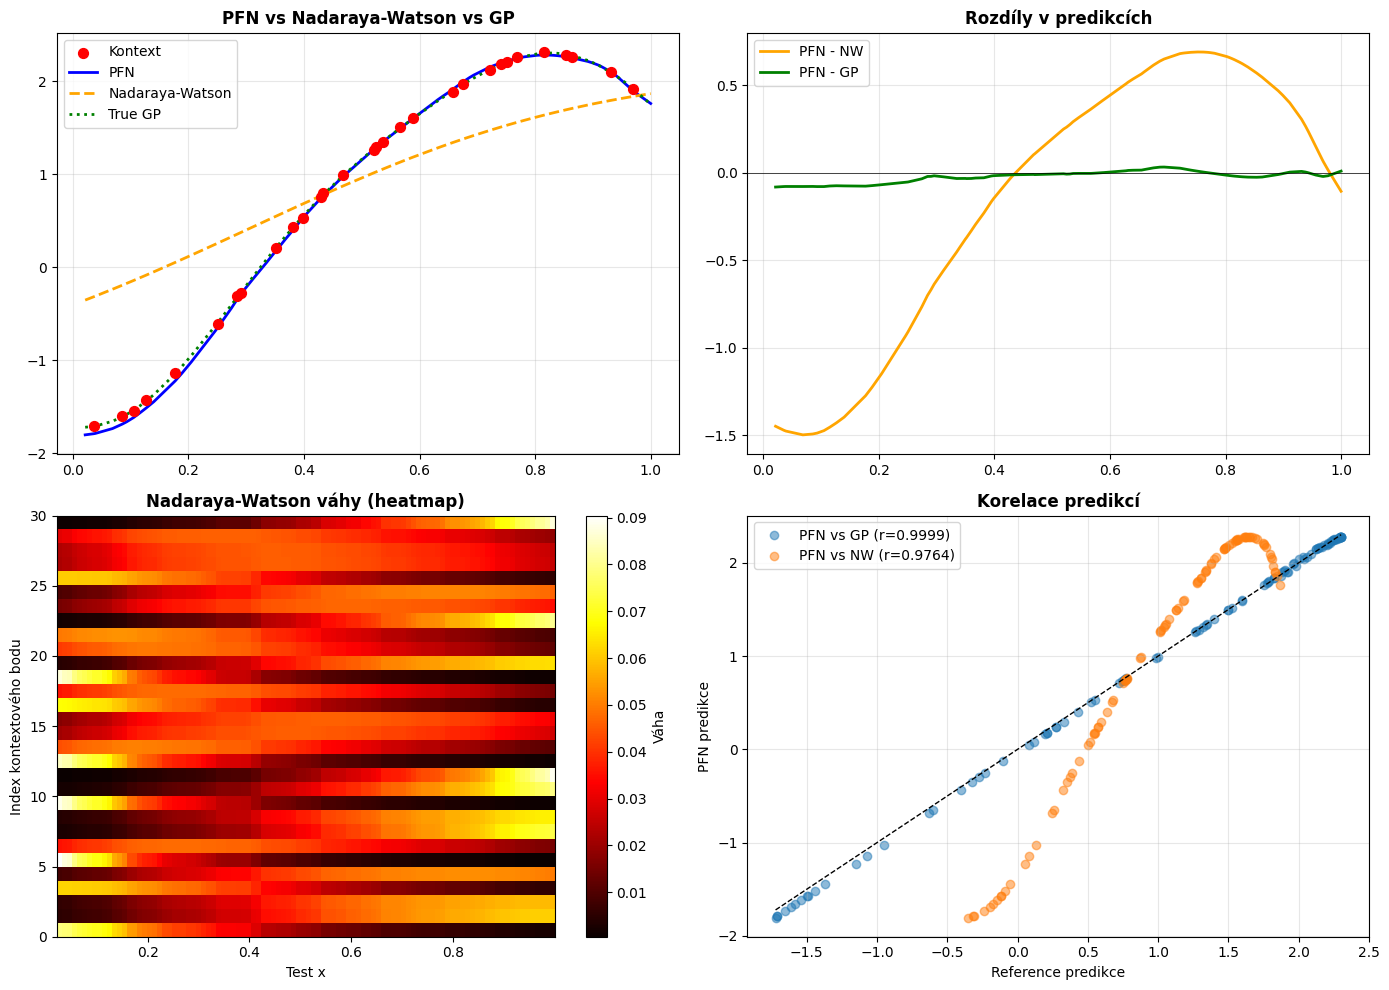

MSE PFN vs GP: 0.001180
MSE PFN vs NW: 0.494442
MSE NW vs GP:  0.457864


In [ ]:
# =============================================
# EXPERIMENT 3: Vizualizace váženého průměru Y
# =============================================
# PFN ~ Nadaraya-Watson estimátor: y_pred = sum(w_i * y_i)

def nadaraya_watson_prediction(train_x, train_y, test_x, lengthscale=0.3):
    """
    Nadaraya-Watson kernel estimátor - to co by měl PFN aproximovat.
    """
    train_x_np = train_x.cpu().numpy().reshape(-1)
    train_y_np = train_y.cpu().numpy().reshape(-1)
    test_x_np = test_x.cpu().numpy().reshape(-1)

    predictions = []
    all_weights = []

    for x_test in test_x_np:
        # RBF váhy
        weights = np.exp(-0.5 * (train_x_np - x_test)**2 / lengthscale**2)
        weights_norm = weights / weights.sum()

        # Vážený průměr
        y_pred = np.sum(weights_norm * train_y_np)
        predictions.append(y_pred)
        all_weights.append(weights_norm)

    return np.array(predictions), np.array(all_weights)

# Generuj data
batch = get_batch_for_gp(batch_size=1, seq_len=100, num_features=1, hyperparameters=hps)
n_context = 20

train_x = batch.x[0, :n_context, 0]
train_y = batch.y[0, :n_context]
test_x = batch.x[0, :, 0]

# PFN predikce
with torch.no_grad():
    logits = loaded_model(batch.x[0, :n_context][None], train_y[None], batch.x[0][None])
pfn_means = loaded_model.criterion.mean(logits)[0].cpu().numpy()

# Nadaraya-Watson predikce
nw_preds, nw_weights = nadaraya_watson_prediction(train_x, train_y, test_x, lengthscale=hps['lengthscale'])

# True GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

kernel = ConstantKernel(hps['outputscale']) * RBF(length_scale=hps['lengthscale'])
gp = GaussianProcessRegressor(kernel=kernel, alpha=hps['noise'])
gp.fit(train_x.cpu().numpy().reshape(-1, 1), train_y.cpu().numpy())
gp_mean = gp.predict(test_x.cpu().numpy().reshape(-1, 1))

# Seřaď
order = test_x.cpu().argsort()
test_x_sorted = test_x.cpu()[order].numpy()

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Porovnání predikcí
ax = axes[0, 0]
ax.scatter(train_x.cpu(), train_y.cpu(), c='red', s=50, zorder=10, label='Kontext')
ax.plot(test_x_sorted, pfn_means[order], 'b-', lw=2, label='PFN')
ax.plot(test_x_sorted, nw_preds[order], 'orange', lw=2, linestyle='--', label='Nadaraya-Watson')
ax.plot(test_x_sorted, gp_mean[order], 'g:', lw=2, label='True GP')
ax.set_title('PFN vs Nadaraya-Watson vs GP', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Rozdíl PFN vs NW
ax = axes[0, 1]
diff_nw = pfn_means[order] - nw_preds[order]
diff_gp = pfn_means[order] - gp_mean[order]
ax.plot(test_x_sorted, diff_nw, 'orange', lw=2, label='PFN - NW')
ax.plot(test_x_sorted, diff_gp, 'green', lw=2, label='PFN - GP')
ax.axhline(y=0, color='black', linestyle='-', lw=0.5)
ax.set_title('Rozdíly v predikcích', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Heatmapa NW vah
ax = axes[1, 0]
im = ax.imshow(nw_weights[order].T, aspect='auto', cmap='hot',
               extent=[test_x_sorted.min(), test_x_sorted.max(), 0, n_context])
ax.set_xlabel('Test x')
ax.set_ylabel('Index kontextového bodu')
ax.set_title('Nadaraya-Watson váhy (heatmap)', fontweight='bold')
plt.colorbar(im, ax=ax, label='Váha')

# 4. Korelace
ax = axes[1, 1]
ax.scatter(gp_mean, pfn_means, alpha=0.5, label=f'PFN vs GP (r={np.corrcoef(gp_mean, pfn_means)[0,1]:.4f})')
ax.scatter(nw_preds, pfn_means, alpha=0.5, label=f'PFN vs NW (r={np.corrcoef(nw_preds, pfn_means)[0,1]:.4f})')
ax.plot([gp_mean.min(), gp_mean.max()], [gp_mean.min(), gp_mean.max()], 'k--', lw=1)
ax.set_xlabel('Reference predikce')
ax.set_ylabel('PFN predikce')
ax.set_title('Korelace predikcí', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE PFN vs GP: {np.mean((pfn_means - gp_mean)**2):.6f}")
print(f"MSE PFN vs NW: {np.mean((pfn_means - nw_preds)**2):.6f}")
print(f"MSE NW vs GP:  {np.mean((nw_preds - gp_mean)**2):.6f}")



*   Tady jsou další ukázky porovnání N-W predikcí s PFN a jak moc dobře odpovídají skutečným predikcím GP




n_context=5: MSE=0.031459 ± 0.046895


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


n_context=10: MSE=0.004306 ± 0.006456
n_context=20: MSE=0.001831 ± 0.001758
n_context=30: MSE=0.000885 ± 0.000556
n_context=50: MSE=0.002729 ± 0.007942


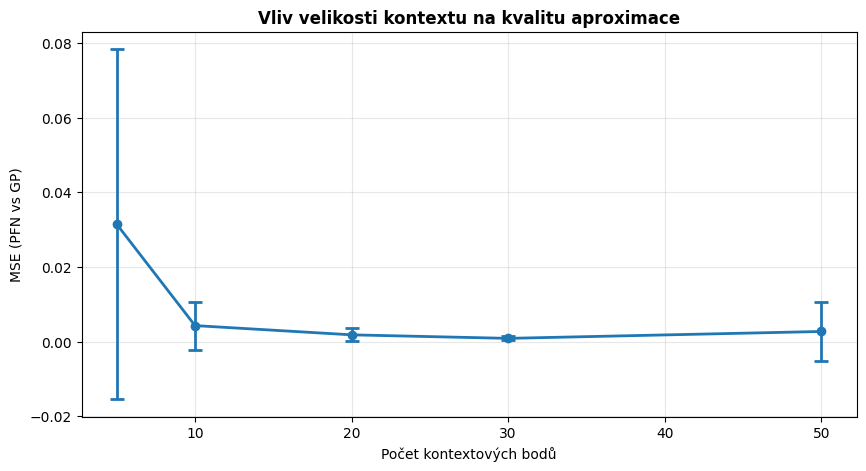

In [ ]:
# =============================================
# EXPERIMENT 4: Jak počet vrstev ovlivňuje aproximaci?
# =============================================
# Hypotéza: Více vrstev = lepší aproximace inverze kernel matice

# Toto vyžaduje modifikovaný model nebo přístup k mezivýstupům
# Pro teď vizualizujeme efekt počtu kontextových bodů

def analyze_context_size_effect(model, hps, context_sizes=[5, 10, 20, 30, 50]):
    """
    Analyzuje jak počet kontextových bodů ovlivňuje kvalitu aproximace.
    """
    results = []

    for n_ctx in context_sizes:
        mses = []
        for _ in range(20):  # 20 opakování
            batch = get_batch_for_gp(batch_size=1, seq_len=100, num_features=1, hyperparameters=hps)

            train_x = batch.x[0, :n_ctx]
            train_y = batch.y[0, :n_ctx]
            test_x = batch.x[0]

            # PFN
            with torch.no_grad():
                logits = model(train_x[None], train_y[None], test_x[None])
            pfn_means = model.criterion.mean(logits)[0].cpu().numpy()

            # GP
            kernel = ConstantKernel(hps['outputscale']) * RBF(length_scale=hps['lengthscale'])
            gp = GaussianProcessRegressor(kernel=kernel, alpha=hps['noise'])
            gp.fit(train_x.cpu().numpy().reshape(-1, 1), train_y.cpu().numpy())
            gp_mean = gp.predict(test_x.cpu()[..., 0].numpy().reshape(-1, 1))

            mse = np.mean((pfn_means - gp_mean)**2)
            mses.append(mse)

        results.append({
            'n_context': n_ctx,
            'mse_mean': np.mean(mses),
            'mse_std': np.std(mses)
        })
        print(f"n_context={n_ctx}: MSE={np.mean(mses):.6f} ± {np.std(mses):.6f}")

    return results

results = analyze_context_size_effect(loaded_model, hps)

# Vizualizace
fig, ax = plt.subplots(figsize=(10, 5))
n_ctx = [r['n_context'] for r in results]
mse_mean = [r['mse_mean'] for r in results]
mse_std = [r['mse_std'] for r in results]

ax.errorbar(n_ctx, mse_mean, yerr=mse_std, marker='o', capsize=5, capthick=2, lw=2)
ax.set_xlabel('Počet kontextových bodů')
ax.set_ylabel('MSE (PFN vs GP)')
ax.set_title('Vliv velikosti kontextu na kvalitu aproximace', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.show()

# Závěr


* PFN se naučil správnou kauzální strukturu GP inference. Testovací body závisí na trénovacích datech (vysoká attention), zatímco trénovací body nezávisí na testovacích (nulová attention). Model tento vztah objevil autonomně z dat bez explicitního zakódování.

* PFN neimplementuje Nadaraya-Watson estimátor (prostý kernel averaging). Nízká korelace s RBF kernelem indikuje, že model aproximuje komplexnější operaci než lokální váhovaný průměr.

* PFN aproximuje true GP posterior s extrémní přesností, zatímco Nadaraya-Watson vykazuje systematické odchylky. Rozdíl o čtyři řády v MSE mezi PFN-GP a NW-GP potvrzuje, že PFN implementuje full Bayesian inference.

* Vliv množství vrstev a velikosti datasetu při trénování na výslednou aproximaci je třeba prozkoumat podrobněji

* PFN se naučil aproximovat kompletní GP posterior formuli: μ(x*) = k(x*, X) @ K^(-1) @ y, nikoli pouze k(x*, X) jako v Nadaraya-Watson estimátoru. Attention mechanismus implicitně implementuje efekt inverze kernel matice K^(-1), která decorreluje blízké trénovací body.